# Dataset Loading and Feature Extraction using RQA

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pyrqa.settings import Settings

import os
folder_paths = [r'C:\Users\ronny\Downloads\z\Z',r'C:\Users\ronny\Downloads\f\F',r'C:\Users\ronny\Downloads\o\O',r'C:\Users\ronny\Downloads\s\S',r'C:\Users\ronny\Downloads\n\N']
# Feature Extraction using RQA
import numpy as np
from pyts.image import RecurrencePlot

def extract_rqa_features(time_series_data):
   
    time_series_data = np.array(time_series_data).reshape(1, -1)

    # Create a Recurrence Plot
    rp = RecurrencePlot(dimension=1, time_delay=1, threshold=None, percentage=20)
    recurrence_matrix = rp.fit_transform(time_series_data)

    # Extract RQA features
    rqa_features = {
        'percentage_recurrence': np.sum(recurrence_matrix) / (recurrence_matrix.shape[0] * recurrence_matrix.shape[1]),
        'determinism': np.sum(np.diagonal(recurrence_matrix, offset=1)) / np.sum(recurrence_matrix),
        'average_diagonal_length': np.sum(np.diagonal(recurrence_matrix, offset=1)) / np.count_nonzero(np.diagonal(recurrence_matrix, offset=1)),
        'entropy': -np.sum(np.multiply(recurrence_matrix, np.log(recurrence_matrix + 1e-10))),  # Add a small value to avoid log(0)
        'average_laminarity': np.sum(np.diagonal(recurrence_matrix, offset=-1)) / np.count_nonzero(np.diagonal(recurrence_matrix, offset=-1)) if np.count_nonzero(np.diagonal(recurrence_matrix, offset=-1)) != 0 else 0,
        # Add more RQA features as needed
    }

    return rqa_features


def batch_process(time_series_data, batch_size=1000):
    num_samples = len(time_series_data)
    num_batches = num_samples // batch_size

    all_features = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        batch_data = time_series_data.iloc[start_idx:end_idx]
        batch_features = extract_rqa_features(batch_data.values)  # Extract NumPy array from DataFrame
        all_features.append(batch_features)

    # Process the last batch if the data size is not divisible by the batch size
    if num_samples % batch_size != 0:
        last_batch_data = time_series_data.iloc[num_batches * batch_size:]
        last_batch_features = extract_rqa_features(last_batch_data.values)  # Extract NumPy array from DataFrame
        all_features.append(last_batch_features)

    # Aggregate the results
    aggregated_features = {}
    for feature_name in all_features[0].keys():
        aggregated_features[feature_name] = np.nanmean([batch[feature_name] for batch in all_features])

    return aggregated_features

# Example usage
batch_size = 1000

df_rqa_list=[]
for folder_path in folder_paths:
    list_files = [file for file in os.listdir(folder_path) if file.endswith('.txt') or file.endswith('.TXT') ]
    for file in list_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path,header=None, delimiter='\t',names=['EEG'])
        label = folder_path.split('/')[-1]
        df_rqa=batch_process(df['EEG'],batch_size=batch_size)
        df_rqa['label']=label
        df_rqa_list.append(pd.DataFrame.from_dict(df_rqa, orient='index').T)

df_rqa_labels=pd.DataFrame()
df_rqa_labels=pd.concat(df_rqa_list,ignore_index=True)        
df_rqa_labels=df_rqa_labels.drop('average_laminarity',axis=1)
df_rqa_labels.to_csv('Feature_rqadata.csv', index=False)


In [23]:
import pandas as pd

file_path = 'C:/Users/Jason/Downloads/Feature_rqadata.csv'
rqadata = pd.read_csv(file_path)

# Display the first few rows of the dataframe
rqadata

,percentage_recurrence,determinism,average_diagonal_length,entropy,label
0,26449.049109,0.002725,32.450274,-9.781356e+07,F
1,102564.344186,0.002158,106.902751,-5.301600e+08,F
2,66609.908767,0.003098,77.267254,-3.029129e+08,F
3,34505.228685,0.002428,36.132326,-1.355573e+08,F
4,75497.819299,0.002213,78.874037,-3.573870e+08,F
...,...,...,...,...,...
495,39572.573971,0.002669,57.762204,-1.595251e+08,Z
496,37614.725225,0.004382,47.332643,-1.529217e+08,Z
497,38776.557390,0.002413,39.402174,-1.566005e+08,Z
498,41486.918763,0.002503,54.418058,-1.708008e+08,Z


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Encoding the categorical labels
encoder = LabelEncoder()
rqadata['label'] = encoder.fit_transform(rqadata['label'])

# Splitting the data into features (X) and target variable (y)
X = rqadata.drop('label', axis=1)
y = rqadata['label']

# Normalizing the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 4), (100, 4), (400,), (100,))

# SVM, Random Forest, and GBM models


In [21]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initializing the models
svm_model = SVC(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
gbm_model = GradientBoostingClassifier(random_state=42)

# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Evaluating the model
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    return report, cm

# Training and evaluating SVM
svm_report, svm_cm = train_and_evaluate(svm_model, X_train, y_train, X_test, y_test)

# Training and evaluating Random Forest
rf_report, rf_cm = train_and_evaluate(rf_model, X_train, y_train, X_test, y_test)

# Training and evaluating GBM
gbm_report, gbm_cm = train_and_evaluate(gbm_model, X_train, y_train, X_test, y_test)

# Results (reports and confusion matrices)

results = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [svm_accuracy, rf_accuracy, gbm_accuracy],
    'Precision': [svm_precision, rf_precision, gbm_precision],
    'Recall': [svm_recall, rf_recall, gbm_recall],
    'F1 Score': [svm_f1, rf_f1, gbm_f1]
})

results

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Precision,Recall,F1 Score
0,SVM,0.40,0.331673,0.40,0.354428
1,Random Forest,0.54,0.538190,0.54,0.533181
2,Gradient Boosting,0.58,0.591643,0.58,0.570975


# Visualizations

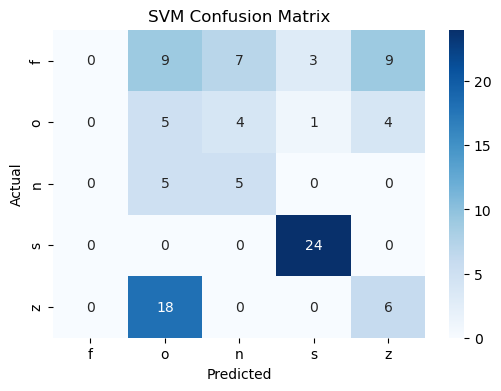

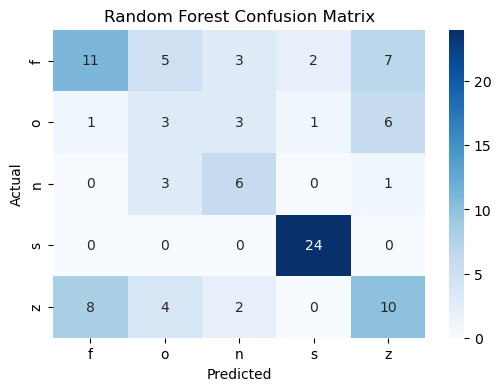

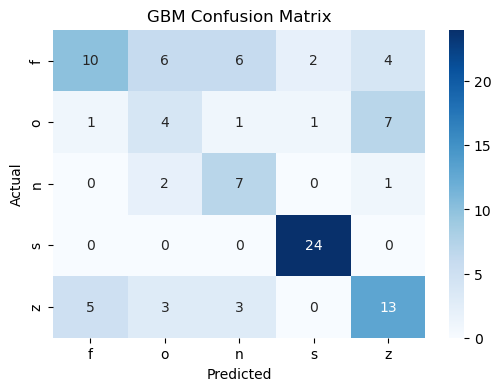

In [22]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix', labels=['f', 'o', 'n', 's', 'z']):
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plotting confusion matrices for each model
plot_confusion_matrix(svm_cm, title='SVM Confusion Matrix')
plot_confusion_matrix(rf_cm, title='Random Forest Confusion Matrix')
plot_confusion_matrix(gbm_cm, title='GBM Confusion Matrix')